# Spam Filter using Multinomial Naive Bayes

We will try to build a model that classified messages with an accuracy greater than or equal to 80%

## Importing Libraries

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline 

## Reading Data

The dataset has been taken from [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)

In [2]:
messages = pd.read_csv("../data/SMSSpamCollection", sep = "\t", header = None)

In [3]:
messages

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
messages.columns = ["Label", "Message"]

In [5]:
messages

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Text(0, 0.5, 'Frequency')

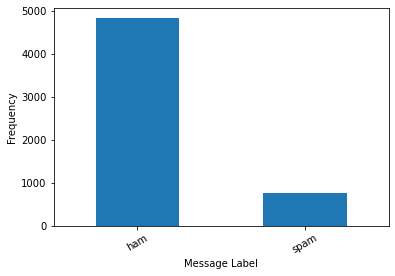

In [6]:
messages["Label"].value_counts().plot.bar(rot = 30)
plt.xlabel("Message Label")
plt.ylabel("Frequency")

In [7]:
messages["Label"].value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

From the documentation of the dataset and from the previous cells we can notice that 86.6% of the messages is classified as non-spam ("ham"), while 13.7% is spam.

## Creating Training and Testing Set

80% of the data will be used for training; the remaining 20% will be used for testing. We will split the randomly

In [8]:
# random data
random_data = messages.sample(frac = 1, random_state = 1)

# lengths of the training and testing data, that will be used aas future indexes
len_train = round(len(random_data) * .8)
len_test = len(random_data) - len_train

print(len_train, len_test, len_train + len_test)

4458 1114 5572


In [9]:
random_data

,Label,Message
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired
4642,ham,Havent.
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...
...,...,...
905,ham,"We're all getting worried over here, derek and..."
5192,ham,Oh oh... Den muz change plan liao... Go back h...
3980,ham,CERI U REBEL! SWEET DREAMZ ME LITTLE BUDDY!! C...
235,spam,Text & meet someone sexy today. U can find a d...


In [10]:
# creating the sets using slicing
training = random_data[:len_train].reset_index(drop = True)
testing = random_data[-len_test:].reset_index(drop = True)

In [11]:
print(training.shape, testing.shape)

(4458, 2) (1114, 2)


In [12]:
training.head()

,Label,Message
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [13]:
testing.head()

,Label,Message
0,ham,Later i guess. I needa do mcat study too.
1,ham,But i haf enuff space got like 4 mb...
2,spam,Had your mobile 10 mths? Update to latest Oran...
3,ham,All sounds good. Fingers . Makes it difficult ...
4,ham,"All done, all handed in. Don't know if mega sh..."


We now check that the proportions of spam and non-spam messages are kept similar to those of the original dataset

In [14]:
training["Label"].value_counts(normalize = True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

In [15]:
testing["Label"].value_counts(normalize = True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

They are kept the same, so we shall proceed.

**NOTE**: the results are completely reproducable, since we extracted a pseudorandom sample

## Data Cleaning

Our classification $C_k$ has two values $spam$ and $non spam$. The formulas are:
$$P(spam|word_1, word_2,\dots , word_n) \propto P(spam)\cdot \prod_{i = 1}^{n}P(word_i|spam)$$
$$P(non\ spam|word_1,word_2,\dots , word_n) \propto P(non\ spam)\cdot \prod_{i = 1}^{n}P(word_i|non\ spam)$$
$$P(word_i|spam) = \frac{X_i + \alpha}{N + \alpha \cdot d}$$ where $X_i$ is represents the frequency of $word_i$ in a spam message, $\alpha$ is the smoothing parameter (we'll set it to 1), $N$ is the number of words in the spam set, $d$ is the number of words in our vocabulary. The same is applied when we condition on "non-spam" messages.

So we will need to clean the data in order to obtain the pieces of information we need.

Recall that the model treats each word indepedently, so we don't care about the entire message. We actually care about the frequencies of each word in a message.

We will do some assumptions: all words will be lowercased and punctuation will be neglegted.

In [16]:
# "\W" is a regex command that matches character that are not a-z, A-Z, 0-9 and _
training["Message"] = training["Message"].str.replace("\W", " ").str.lower()

C:\Users\Sandro Mikautadze\AppData\Local\Temp\ipykernel_13048\1127281784.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  training["Message"] = training["Message"].str.replace("\W", " ").str.lower()


In [17]:
training.head()

,Label,Message
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


In [18]:
# creating the vocabulary
vocabulary = []
training["Message"] = training["Message"].str.split()
for message in training["Message"]:
    for word in message:
        if word not in vocabulary:
            vocabulary.append(word)

NameError: name 'vocavulary' is not defined

In [19]:
# checking that there are no duplicates in the vocabulary
print(len(vocabulary) == len(set(vocabulary)))

True


In [149]:
vocabulary[:5]

['yep', 'by', 'the', 'pretty', 'sculpture']

In [28]:
d = len(vocabulary)
print(d)

7783


There are 7783 unique words in the messages. Now we will split the `Message` column into multiple columns for each word in the vocabulary, setting the values as the frequencies of the words in each message. We will do so creating a dictionary first and then converting it to a dataframe that we will concatenate to the original training dataset.

In [55]:
# creating the dictionary that will be converted to a dataframe
word_freq_per_message = {word : [0] * len(training["Message"]) for word in vocabulary}

# adding the frequencies to word_freq_per_message
for i, word in enumerate(training["Message"]):
    for word in message: # recall that 'message' is a list of words, saved as strings
        word_freq_per_message[word][i] += 1
        
words_freq_per_message = pd.DataFrame(word_freq_per_message)
words_freq_per_message

,yep,by,the,pretty,sculpture,yes,princess,are,you,going,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
training_final = pd.concat([training, words_freq_per_message], axis = 1)

In [57]:
training_final

,Label,Message,yep,by,the,pretty,sculpture,yes,princess,are,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,ham,"[sorry, i, ll, call, later, in, meeting, any, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4454,ham,"[babe, i, fucking, love, you, too, you, know, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4455,spam,"[u, ve, been, selected, to, stay, in, 1, of, 2...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4456,ham,"[hello, my, boytoy, geeee, i, miss, you, alrea...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Calculating Probabilities

Now that we have a dataset that is useful for our scenario, we can proceed doing our calculation. Since the formulas are a bit long, I will repaste them here:
$$P(spam|word_1, word_2,\dots , word_n) \propto P(spam)\cdot \prod_{i = 1}^{n}P(word_i|spam)$$
$$P(non\ spam|word_1,word_2,\dots , word_n) \propto P(non\ spam)\cdot \prod_{i = 1}^{n}P(word_i|non\ spam)$$
$$P(word_i|spam) = \frac{X_i + \alpha}{N + \alpha \cdot d}$$ where $X_i$ is represents the frequency of $word_i$ in a spam message, $\alpha$ is the smoothing parameter (we'll set it to 1), $N$ is the number of words in the spam set, $d$ is the number of words in our vocabulary. The same is applied when we condition on "non-spam" messages.

Let's start with $P(spam)$ and $P(non\ spam)$.

In [150]:
prob_spam = len(training_final[training_final["Label"] == "spam"]) / len(training_final["Label"])
prob_nonspam = 1 - prob_spam
print(prob_spam, prob_nonspam)

0.13458950201884254 0.8654104979811574


This is no surprise to us, since the probability of being spam or non spam is the frequency in the dataset. 

Next, let's go on calculating $P(word_i|C_k)$ where $C_k$ is either $spam$ or $non\ spam$. Since there are 7783 words in the vocabulary, and we need to calculate the probabilities in both cases, we need to so 15566 computations.
Thanks God my probability professor never asked me anything this repetitive!

In [154]:
# calculating P(word_i|C_k)
spam_messages = training_final[training_final["Label"] == "spam"]
nonspam_messages = training_final[training_final["Label"] == "ham"]

alpha = 1
n_spam = spam_messages["Message"].apply(len).sum()
n_nonspam = nonspam_messages["Message"].apply(len).sum()
# we defined "d" previously in our code
print(alpha, n_spam, n_nonspam, d)

prob_word_given_spam = {}
prob_word_given_nonspam = {}

for word in vocabulary:
    prob_word_given_spam[word] = (spam_messages[word].sum() + alpha) / (n_spam + alpha * d)
    prob_word_given_nonspam[word] = (nonspam_messages[word].sum() + alpha) / (n_nonspam + alpha * d)

1 15190 57237 7783


In [155]:
print(dict(list(prob_word_given_spam.items())[:3]))

{'yep': 4.3529360553693465e-05, 'by': 4.3529360553693465e-05, 'the': 4.3529360553693465e-05}


In [156]:
print(dict(list(prob_word_given_nonspam.items())[:3]))

{'yep': 1.537988311288834e-05, 'by': 1.537988311288834e-05, 'the': 1.537988311288834e-05}


**NOTE**: doing so many calculations before the classification is what makes Naive Bayes very fast! If we did not do so, we would need to do all these calculations for every new message! Now, instead, most of them are already done

## Building the Classifier

In [159]:
def classify(message):
    if not isinstance(message, str):
        raise Exception("Argument must be a string")
    
    message = re.sub("\W", " ", message)
    message = message.lower().split()
    
    prob_spam_given_message = prob_spam
    prob_nonspam_given_message = prob_nonspam
    for word in message:
        if word in prob_word_given_spam:
            prob_spam_given_message *= prob_word_given_spam[word]
        if word in prob_word_given_nonspam:
            prob_nonspam_given_message *= prob_word_given_nonspam[word]
    # we added these if clauses to avoid issues when a word of a message is not present in our list (see README for more)
    
    if prob_spam_given_message > prob_nonspam_given_message:
        print(f"P(spam|message) = {prob_spam_given_message}\nP(non spam|message) = {prob_nonspam_given_message}\nMessage Type: spam")
    if prob_spam_given_message < prob_nonspam_given_message:
        print(f"P(spam|message) = {prob_spam_given_message}\nP(non spam|message) = {prob_nonspam_given_message}\nMessage Type: non-spam")

In [160]:
classify(3)

Exception: Argument must be a string

In [161]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(spam|message) = 7.55182248895403e-41
P(non spam|message) = 4.166769463337442e-44
Message Type: spam


In [162]:
classify("Sounds good, Tom, then see u there")

P(spam|message) = 3.9855402384039956e-32
P(non spam|message) = 1.7615436249913157e-34
Message Type: spam
